In [1]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime
import time
import os
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import statsmodels.api as sm
from functools import reduce

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")



In [2]:
df_income = pd.read_csv('../data/income_statement.csv')
df_balance = pd.read_csv('../data/balance_sheet.csv')
df_cash_flow = pd.read_csv('../data/cash_flow_statement.csv')   
df_earnings = pd.read_csv('../data/earnings.csv')   
df_overview = pd.read_csv('../data/company_overview.csv')

In [3]:
df_technical = pd.read_csv('../data/technical_data.csv')

In [4]:
df_price = pd.read_csv('../data/tech_stock_daily_price.csv')

In [5]:
df_sentiment = pd.read_csv('../data/daily_sentiment_score.csv')

In [60]:
df_SP500 = pd.read_csv('../data/SP500_daily_price.csv')

In [64]:
df_income['fiscalDateEnding'] = pd.to_datetime(df_income['fiscalDateEnding'])
df_balance['fiscalDateEnding'] = pd.to_datetime(df_balance['fiscalDateEnding'])
df_cash_flow['fiscalDateEnding'] = pd.to_datetime(df_cash_flow['fiscalDateEnding'])
df_earnings['fiscalDateEnding'] = pd.to_datetime(df_earnings['fiscalDateEnding'])
df_technical['date'] = pd.to_datetime(df_technical['date'])
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])


In [66]:
df_income = df_income.sort_values(by=['symbol', 'fiscalDateEnding'])
df_balance = df_balance.sort_values(by=['symbol', 'fiscalDateEnding'])
df_cash_flow = df_cash_flow.sort_values(by=['symbol', 'fiscalDateEnding'])
df_earnings = df_earnings.sort_values(by=['symbol', 'fiscalDateEnding'])
df_technical = df_technical.sort_values(by=['ticker', 'date'])
df_price = df_price.sort_values(by=['ticker', 'Date'])
df_sentiment = df_sentiment.sort_values(by=['ticker', 'date'])
df_SP500 = df_SP500.sort_values(by=['ticker', 'Date'])

In [67]:
symbol='AAPL'

In [68]:
income_data = df_income[df_income['symbol'] == symbol]
balance_data = df_balance[df_balance['symbol'] == symbol]
overview_data = df_overview[df_overview['symbol'] == symbol]
earnings_data = df_earnings[df_earnings['symbol'] == symbol]
cash_flow_data = df_cash_flow[df_cash_flow['symbol'] == symbol]
technical_data = df_technical[df_technical['ticker']==symbol]
price_data = df_price[df_price['ticker'] == symbol]
sentiment_data = df_sentiment[df_sentiment['ticker'] == symbol]

In [69]:
competitors_data = df_price[df_price['ticker'].isin([ 'MSFT', 'GOOGL', 'AMZN', 'META'])]

In [70]:
competitors_data = competitors_data.pivot(index='Date', columns='ticker', values='Close')
competitors_data = competitors_data.reset_index() 

In [71]:
competitors_data[competitors_data.columns[1:]] = competitors_data[competitors_data.columns[1:]].pct_change()

In [72]:
competitors_sentiment = df_sentiment[df_sentiment['ticker'].isin([ 'MSFT', 'GOOGL', 'AMZN', 'META'])]
competitors_sentiment = competitors_sentiment.pivot(index='date', columns='ticker', values='sentiment_score')
competitors_sentiment = competitors_sentiment.reset_index()

In [104]:
SP500_data = df_SP500.rename(columns={'Close': 'SP500_Close'})
SP500_data = SP500_data[['Date', 'SP500_Close']]

In [105]:
dict_data={
    'AAPL':
           {
               'start_date':'2023-12-29',
               'end_date':'2025-06-29', 
           }
}

In [106]:
start_date = dict_data[symbol]['start_date']
end_date = dict_data[symbol]['end_date']

In [107]:
income_data = income_data[income_data['fiscalDateEnding'] >= start_date]
balance_data = balance_data[balance_data['fiscalDateEnding'] >= start_date]
cash_flow_data = cash_flow_data[cash_flow_data['fiscalDateEnding']>= start_date]
earnings_data = earnings_data[earnings_data['fiscalDateEnding'] >= start_date]
technical_data = technical_data[technical_data['date']>=start_date]
price_data = price_data[price_data['Date'] >= start_date]
sentiment_data = sentiment_data[sentiment_data['date'] >= start_date]
competitors_data = competitors_data[competitors_data['Date'] >= start_date]
competitors_sentiment = competitors_sentiment[competitors_sentiment['date'] >= start_date]

In [108]:
competitors_sentiment = competitors_sentiment.rename(columns={
    'MSFT': 'MSFT_sentiment',
    'GOOGL': 'GOOGL_sentiment',
    'AMZN': 'AMZN_sentiment',
    'META': 'META_sentiment'
    })

In [109]:
earliest_date = max(technical_data['date'].min(),price_data['Date'].min(), earnings_data['fiscalDateEnding'].min(), income_data['fiscalDateEnding'].min(), balance_data['fiscalDateEnding'].min(), cash_flow_data['fiscalDateEnding'].min())
latest_date = min(technical_data['date'].max(),price_data['Date'].max(),sentiment_data['date'].max())

In [110]:
print(f"earliest_date: {earliest_date}")
print(f"latest_date: {latest_date}") 

earliest_date: 2023-12-31 00:00:00
latest_date: 2025-07-01 00:00:00


In [111]:
income_data = income_data.drop(columns=['symbol','reportedCurrency'])

KeyError: "['symbol', 'reportedCurrency'] not found in axis"

In [ ]:
all_nan_columns = income_data.columns[income_data.isna().all()].tolist()

In [112]:
income_data = income_data.drop(columns=all_nan_columns)

KeyError: "['propertyPlantEquipment', 'accumulatedDepreciationAmortizationPPE', 'intangibleAssets', 'intangibleAssetsExcludingGoodwill', 'goodwill', 'investments', 'otherNonCurrentAssets', 'deferredRevenue', 'currentDebt', 'capitalLeaseObligations', 'longTermDebtNoncurrent', 'treasuryStock'] not found in axis"

In [113]:
balance_data = balance_data.drop(columns=['symbol','reportedCurrency'])

KeyError: "['symbol', 'reportedCurrency'] not found in axis"

In [114]:
all_nan_columns = balance_data.columns[balance_data.isna().all()].tolist()

In [115]:
balance_data = balance_data.drop(columns=all_nan_columns)

In [116]:
cash_flow_data = cash_flow_data[['fiscalDateEnding','operatingCashflow']]

In [117]:
earnings_data = earnings_data[['fiscalDateEnding','reportedEPS']]

In [118]:
merged_earnings_df = reduce(lambda left, right: pd.merge(left, right, on='fiscalDateEnding'), [income_data, balance_data, cash_flow_data, earnings_data])

In [119]:
merged_earnings_df = merged_earnings_df.sort_values(by='fiscalDateEnding')

### Combining dfs

In [159]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')


In [160]:
df_dates = pd.DataFrame(all_dates,columns=['all_date'])

In [161]:
df = df_dates.merge(price_data[['Date','Close']], left_on='all_date',right_on='Date', how='left')

In [162]:
df = df.merge(merged_earnings_df, left_on='all_date', right_on='fiscalDateEnding', how='left')

In [163]:
df[merged_earnings_df.columns] = df[merged_earnings_df.columns].fillna(method='ffill')

In [164]:
df = df.merge(sentiment_data[['date','sentiment_score']], left_on='all_date', right_on='date', how='left')

In [165]:
df['sentiment_score'] = df['sentiment_score'].fillna(0)

In [166]:
technical_data = technical_data.drop(columns=['ticker','company_name'])

KeyError: "['ticker', 'company_name'] not found in axis"

In [167]:
df = df.merge(technical_data, left_on='all_date', right_on='date', how='left')

In [168]:
df = df.merge(competitors_data, left_on='all_date', right_on='Date', how='left')

In [169]:
df = df.merge(SP500_data, left_on='all_date', right_on='Date', how='left')

In [170]:
# df = df.merge(competitors_sentiment, left_on='all_date', right_on='date', how='left')

In [171]:
# df[['MSFT_sentiment','META_sentiment','AMZN_sentiment']] = df[['MSFT_sentiment','META_sentiment','AMZN_sentiment']].fillna(0)

In [172]:
df = df[(df['all_date']>= earliest_date) & (df['all_date'] < latest_date)]

In [173]:
df = df[~(df['Close'].isna())]

In [174]:
df = df.drop(columns=['all_date','Date_x','Date_y','fiscalDateEnding','date_x','date_y','Date'])

In [175]:
df

,Close,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,interestExpense,...,Real Middle Band_100,Real Lower Band_100,Real Upper Band_200,Real Middle Band_200,Real Lower Band_200,AMZN,GOOGL,META,MSFT,SP500_Close
4,185.64,5.485500e+10,1.195750e+11,6.472000e+10,6.472000e+10,4.037300e+10,6.786000e+09,7.696000e+09,1.453200e+10,1.002000e+09,...,180.7884,164.0538,199.2234,177.9953,156.7673,-0.013229,-0.010881,-0.021669,-0.013749,472.65
5,184.25,5.485500e+10,1.195750e+11,6.472000e+10,6.472000e+10,4.037300e+10,6.786000e+09,7.696000e+09,1.453200e+10,1.002000e+09,...,180.8554,164.1407,199.0912,178.1436,157.1961,-0.009738,0.005428,-0.005256,-0.000728,468.79
6,181.91,5.485500e+10,1.195750e+11,6.472000e+10,6.472000e+10,4.037300e+10,6.786000e+09,7.696000e+09,1.453200e+10,1.002000e+09,...,180.8986,164.2091,198.9742,178.2684,157.5626,-0.026268,-0.018212,0.007693,-0.007178,467.28
7,181.18,5.485500e+10,1.195750e+11,6.472000e+10,6.472000e+10,4.037300e+10,6.786000e+09,7.696000e+09,1.453200e+10,1.002000e+09,...,180.9180,164.2377,198.8768,178.3803,157.8838,0.004634,-0.004839,0.013914,-0.000516,467.92
10,185.56,5.485500e+10,1.195750e+11,6.472000e+10,6.472000e+10,4.037300e+10,6.786000e+09,7.696000e+09,1.453200e+10,1.002000e+09,...,181.0008,164.3378,198.7881,178.5211,158.2541,0.026577,0.022913,0.019065,0.018872,474.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,201.50,4.486700e+10,9.535900e+10,5.049200e+10,5.049200e+10,2.958900e+10,6.728000e+09,8.550000e+09,1.527800e+10,1.002000e+09,...,214.1204,179.9170,257.0084,223.3027,189.5969,-0.005818,-0.008701,0.023712,0.018014,600.15
543,200.30,4.486700e+10,9.535900e+10,5.049200e+10,5.049200e+10,2.958900e+10,6.728000e+09,8.550000e+09,1.527800e+10,1.002000e+09,...,213.7354,179.7861,257.0625,223.2037,189.3449,0.020626,0.009565,0.019570,0.008457,606.78
544,201.56,4.486700e+10,9.535900e+10,5.049200e+10,5.049200e+10,2.958900e+10,6.728000e+09,8.550000e+09,1.527800e+10,1.002000e+09,...,213.3806,179.6721,257.0989,223.1034,189.1079,-0.003666,0.023445,-0.004942,0.004407,607.12
545,201.00,4.486700e+10,9.535900e+10,5.049200e+10,5.049200e+10,2.958900e+10,6.728000e+09,8.550000e+09,1.527800e+10,1.002000e+09,...,213.0361,179.5334,257.1438,223.0081,188.8724,0.024199,0.016757,0.024567,0.010523,611.87


In [176]:
df['Return'] = df['Close'].pct_change().fillna(0)

In [177]:
lags = [1, 2, 3, 5, 10, 20]
for lag in lags:
    df[f'return_lag{lag}'] = df['Return'].shift(lag)
    df[f'sentiment_lag{lag}'] = df['sentiment_score'].shift(lag)
    df[f'MSFT_lag{lag}'] = df['MSFT'].shift(lag)
    df[f'GOOGL_lag{lag}'] = df['GOOGL'].shift(lag)
    df[f'AMZN_lag{lag}'] = df['AMZN'].shift(lag)    
    df[f'META_lag{lag}'] = df['META'].shift(lag)
    df[f'SP500_lag{lag}'] = df['SP500_Close'].shift(lag)
    # df[f'MSFT_sentiment_lag{lag}'] = df['MSFT_sentiment'].shift(lag)
    # df[f'AMZN_sentiment_lag{lag}'] = df['AMZN_sentiment'].shift(lag)
    # df[f'META_sentiment_lag{lag}'] = df['META_sentiment'].shift(lag)


In [178]:
df = df[20:]

In [179]:
df['Direction'] = df['Return'].apply(lambda x: 1 if x > 0 else 0)

In [180]:
### Exclude Outliers
df = df[(np.abs(df['Return'] - df['Return'].mean()) <= (3 * df['Return'].std()))]
# df = df[df['Date']!='2014-06-09']
# df = df[df['Date']!='2020-08-31']
# df = df[df['Date']!='2020-09-01']


In [181]:
df = df.fillna(method='ffill')

In [182]:
df_X = df.drop(columns=['Close','Return','Direction'])

In [183]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_X_scaled = scaler.fit_transform(df_X.values)


In [184]:
df_Y = df['Direction']

In [185]:
from sklearn.ensemble import RandomForestClassifier

In [186]:
X_train, X_test, y_train, y_test = train_test_split(
    df_X_scaled, df_Y, test_size=0.2, random_state=32
)

# 5. Initialize and fit the Random Forest model
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,   
    random_state=50
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)



In [187]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Number of test samples:", len(y_test))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Number of test samples: 70
Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        35
           1       0.78      0.83      0.81        35

    accuracy                           0.80        70
   macro avg       0.80      0.80      0.80        70
weighted avg       0.80      0.80      0.80        70

Confusion Matrix:
 [[27  8]
 [ 6 29]]


In [188]:
import pickle

# Save the model
pickle.dump(rf, open('model.pkl', 'wb'))

# Load the model
# loaded_model = pickle.load(open('model.pkl', 'rb'))


In [189]:
df_Y = df['Return']

In [190]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(
    df_X_scaled, df_Y, test_size=0.2, random_state=62
)

# 5. Initialize and fit the Random Forest model
rf = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Let trees expand until all leaves are pure
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

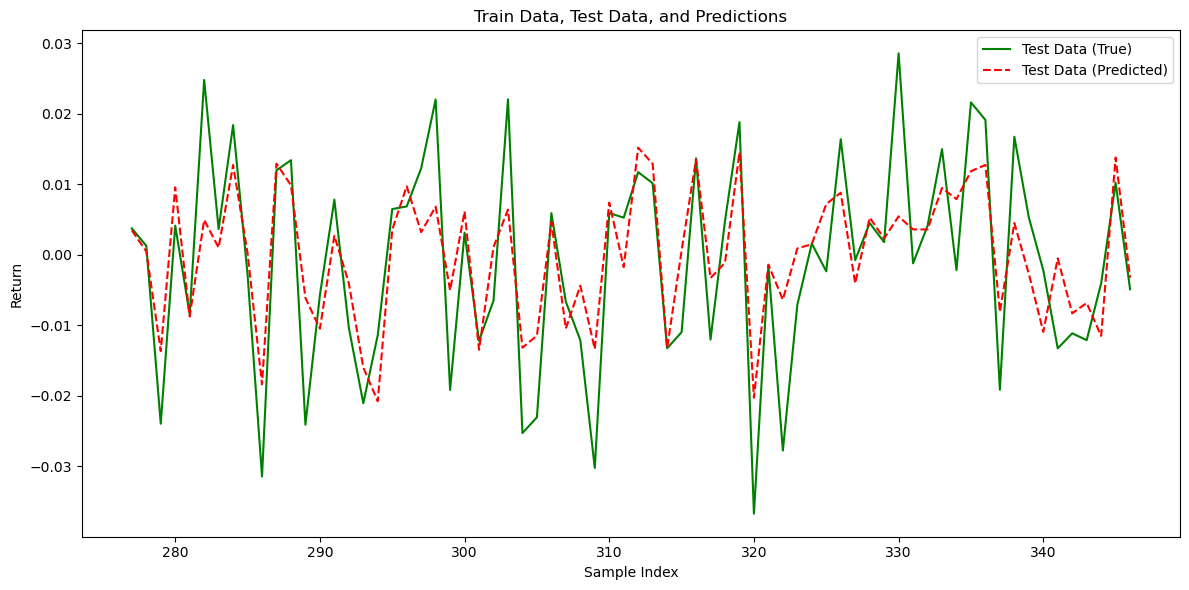

In [191]:
import numpy as np
import matplotlib.pyplot as plt


# Indices for plotting
train_idx = range(len(y_train))
test_idx = range(len(y_train), len(y_train) + len(y_test))

plt.figure(figsize=(12, 6))

# Plot true values for train and test
# plt.plot(train_idx, y_train, label='Train Data (True)', color='blue')
plt.plot(test_idx, y_test, label='Test Data (True)', color='green')

# Plot predictions for test set
plt.plot(test_idx, y_pred, label='Test Data (Predicted)', color='red', linestyle='--')

plt.xlabel('Sample Index')
plt.ylabel('Return')
plt.title('Train Data, Test Data, and Predictions')
plt.legend()
plt.tight_layout()
plt.show()


In [192]:
diff = y_pred - y_test

In [193]:
df_diff = pd.DataFrame(diff)

In [194]:
df_diff['round'] = df_diff['Return'].round(3)

In [195]:
df_plot = df_diff['round'].value_counts().sort_index()

Text(0.5, 1.0, 'Distribution of Return Differences')

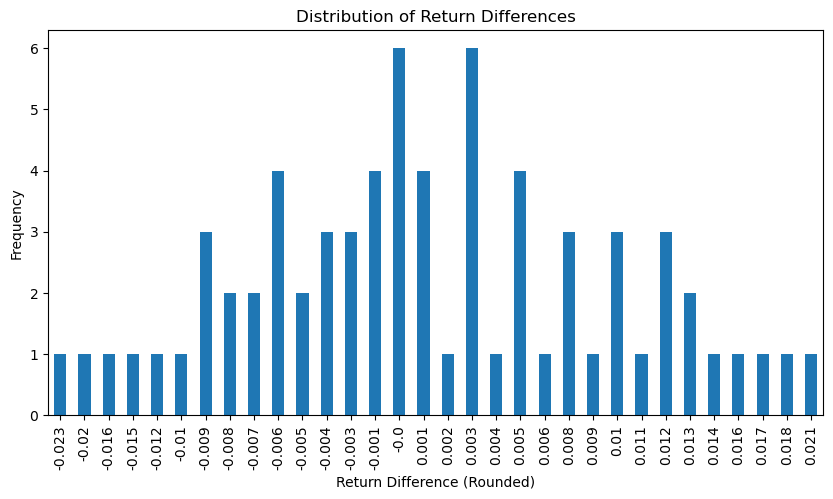

In [196]:
df_plot.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Return Difference (Rounded)')   
plt.ylabel('Frequency')
plt.title('Distribution of Return Differences')

In [198]:
# 7. Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# # 8. (Optional) Hyperparameter tuning with GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 5, 10],
#     'max_features': ['auto', 'sqrt']
# }
# grid_search = GridSearchCV(
#     RandomForestRegressor(random_state=42),
#     param_grid,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )
# grid_search.fit(X_train, y_train)
# print("Best parameters found:", grid_search.best_params_)

# 9. Feature importance
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=df_X.columns)
sorted_importance = feature_importance.sort_values(ascending=False)

print(sorted_importance.head(20))
# for name, importance in zip(df_X.columns, importances):
#     print(f"{name}: {importance:.3f}")


Root Mean Squared Error: 0.009
R^2 Score: 0.636
WILLR_5            0.350104
AMZN               0.078099
MSFT               0.067321
return_lag1        0.048475
SlowK_None         0.028375
SlowD_None         0.027388
GOOGL              0.021331
RSI_5              0.019353
MSFT_lag1          0.014653
AMZN_lag1          0.013025
META               0.012874
sentiment_score    0.012406
return_lag3        0.011432
return_lag2        0.010590
MACD_Hist_None     0.009678
MACD_None          0.009654
RSI_20             0.008658
AMZN_lag2          0.007306
META_lag20         0.007208
MSFT_lag20         0.007065
dtype: float64
